# Data Augmentation using SNGANs (Spectrally Normalized Generative adversarial networks)

# Final Framework

1. Importing all necessary functions and libraries

2. Defining the Generator

3. Defining the Discriminator

4. Testing integration

5. Dataset
  - Defining variables
  - Importing dataset
  - Visualising dataset

6. Training
  - Initialising model weights and bias
  - Training and validating model
  - Saving model

7. Creating Augmented data

# 1. Importing all necessary functions and Libraries

In [ ]:
import torch
import numpy as np
import torchvision
from torch import nn
from torch import optim
from google.colab import drive
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import make_grid

%matplotlib inline

# 2. Defining the Generator

In [ ]:
# generator class

class generator(nn.Module):
  
  def __init__(self):
    
    super(generator, self).__init__()
    
    self.gen = nn.Sequential(
        
        # first block

        nn.ConvTranspose2d(in_channels=100, 
                           out_channels=2048,
                           kernel_size=4,
                           stride=1,
                           padding=0,
                           bias=False),
        nn.BatchNorm2d(num_features=2048),
        nn.ReLU(),
            
        # second block

        nn.ConvTranspose2d(in_channels=2048,
                           out_channels=1024,
                           kernel_size=4,
                           stride=2,
                           padding=1,
                           bias=False),
        nn.BatchNorm2d(num_features=1024),
        nn.ReLU(),
            
        # third block

        nn.ConvTranspose2d(in_channels=1024,
                           out_channels=512,
                           kernel_size=4,
                           stride=2,
                           padding=1,
                           bias=False),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
            
        # fourth block
        
        nn.ConvTranspose2d(in_channels=512,
                           out_channels=256,
                           kernel_size=4,
                           stride=2,
                           padding=1,
                           bias=False),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),

        # fifth block
        nn.ConvTranspose2d(in_channels=256,
                           out_channels=128,
                           kernel_size=4,
                           stride=2,
                           padding=1,
                           bias=False),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
            
        # sixth block
        nn.ConvTranspose2d(in_channels=128,
                           out_channels=64,
                           kernel_size=4,
                           stride=2,
                           padding=1,
                           bias=False),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
            
        # final block
        nn.ConvTranspose2d(in_channels=64, 
                           out_channels=1,
                           kernel_size=4,
                           stride=2,
                           padding=1,
                           bias=False),
        nn.Tanh()

        )
    
    # forward driving function

  def forward(self, x):
    x = self.gen(x)
    return x

# 3. Defining the Discriminator

In [ ]:
# discriminator class

class discriminator(nn.Module):
  
  def __init__(self):
    
    super(discriminator, self).__init__()

    self.disc = nn.Sequential(
        
        # first block

        nn.utils.spectral_norm(nn.Conv2d(in_channels=1,
                  out_channels=64,
                  kernel_size=4,
                  stride=2,
                  padding=1, 
                  bias=False)),
        nn.LeakyReLU(negative_slope=0.2),
            
        # second block
            
        nn.utils.spectral_norm(nn.Conv2d(in_channels=64,
                  out_channels=128,
                  kernel_size=4,
                  stride=2,
                  padding=1,
                  bias=False)),
        nn.BatchNorm2d(num_features=128),
        nn.LeakyReLU(negative_slope=0.2),
            
        # (batch_size, 128, 16, 16)
        nn.utils.spectral_norm(nn.Conv2d(in_channels=128,
                  out_channels=256,
                  kernel_size=4,
                  stride=2,
                  padding=1,
                  bias=False)),
        nn.BatchNorm2d(num_features=256),
        nn.LeakyReLU(negative_slope=0.2),
            
        # (batch_size, 256, 8, 8)
        nn.utils.spectral_norm(nn.Conv2d(in_channels=256,
                  out_channels=512,
                  kernel_size=4,
                  stride=2,
                  padding=1,
                  bias=False)),
        nn.BatchNorm2d(num_features=512),
        nn.LeakyReLU(negative_slope=0.2),

        # (batch_size, 512, 8, 8)
        nn.utils.spectral_norm(nn.Conv2d(in_channels=512,
                  out_channels=1024,
                  kernel_size=4,
                  stride=2,
                  padding=1,
                  bias=False)),
        nn.BatchNorm2d(num_features=1024),
        nn.LeakyReLU(negative_slope=0.2),

        # (batch_size, 256, 8, 8)
        nn.utils.spectral_norm(nn.Conv2d(in_channels=1024,
                  out_channels=2048,
                  kernel_size=4,
                  stride=2,
                  padding=1,
                  bias=False)),
        nn.BatchNorm2d(num_features=2048),
        nn.LeakyReLU(negative_slope=0.2),
            
        # (batch_size, 512, 4, 4)
        nn.utils.spectral_norm(nn.Conv2d(in_channels=2048,
                  out_channels=1,
                  kernel_size=4,
                  stride=1,
                  padding=0,
                  bias=False)),
        nn.Sigmoid()
        
        )
        
  # forward driving function

  def forward(self, x):
    x = self.disc(x)
    return x

# 4. Testing Integration

In [ ]:
# creating model instances

gen = generator()
disc = discriminator()

# testing integration

print(gen(torch.randn(30, 100, 1, 1)).shape)
print(disc(torch.randn(30, 1, 256, 256)).shape)

torch.Size([30, 1, 256, 256])
torch.Size([30, 1, 1, 1])


# 5. Dataset

Defining variables

In [ ]:
# to access dataset
drive.mount('/content/drive')
root = "/content/drive/My Drive/Colab Notebooks/x_ray_tb/data/train_small/tb"

# training purpose

criterion = nn.BCELoss()
gpu = torch.device(0)

n_epochs = 3500
batch_size = 3
cur_step = 0
epoch = 0

# to validate model

test_noise = torch.randn((4, 100, 1, 1)).to(gpu)

Mounted at /content/drive


Importing dataset

In [ ]:
# function to import dataset

def build_data_loader(batch_size):
  dataset = torchvision.datasets.ImageFolder(
      root=root,
      transform=torchvision.transforms.Compose([
                                                torchvision.transforms.Resize(256),
                                                torchvision.transforms.CenterCrop(256),
                                                torchvision.transforms.Grayscale(),
                                                torchvision.transforms.ToTensor() 
                                                ])
      )
  
    
  return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

# importing dataset

data_loader = build_data_loader(batch_size)

Visualising dataset

torch.Size([8, 1, 256, 256])


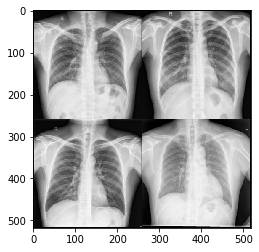

In [ ]:
# function to visualise dataset

def show_tensor_images(image_tensor, num_images=4, nrow=2, show=True):
  image_tensor = (image_tensor + 1) / 2
  image_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(image_unflat[:num_images], nrow=nrow, normalize=True)
  npy_img = image_grid.numpy()
  plt.imshow(np.transpose(npy_img, (1, 2, 0)), interpolation='nearest')
  if show:
    plt.show()

# visualising dataset

for data, _ in build_data_loader(8):
    test_images = data
    break
    
print(test_images.shape)
show_tensor_images(test_images)

# 6. Training

Initialising weights and bias

In [ ]:
# moving the models to gpu

gen = gen.to(gpu)
disc = disc.to(gpu)

# creating optimizers

disc_opt = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_opt = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))

# function to inintialise weights and bias

def weights_init(m):
  
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

# initialising weights and bias

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Training and validating model


Epoch: 0/3500
Example images:


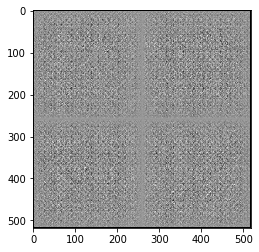


Epoch: 0	Batch: 117/118
Generator Loss: 4.15729284286499
Discriminator Loss: 0.03198970854282379

Epoch: 1	Batch: 117/118
Generator Loss: 2.407848596572876
Discriminator Loss: 0.4136408567428589

Epoch: 2	Batch: 117/118
Generator Loss: 1.5402319431304932
Discriminator Loss: 0.742102861404419

Epoch: 3	Batch: 117/118
Generator Loss: 1.0066581964492798
Discriminator Loss: 1.3055918216705322

Epoch: 4	Batch: 117/118
Generator Loss: 1.1121180057525635
Discriminator Loss: 1.3468365669250488

Epoch: 5	Batch: 117/118
Generator Loss: 1.06705641746521
Discriminator Loss: 1.5760722160339355

Epoch: 6	Batch: 117/118
Generator Loss: 1.2851169109344482
Discriminator Loss: 1.0006871223449707

Epoch: 7	Batch: 117/118
Generator Loss: 1.438288927078247
Discriminator Loss: 1.1068167686462402

Epoch: 8	Batch: 117/118
Generator Loss: 1.1704399585723877
Discriminator Loss: 1.0954645872116089

Epoch: 9	Batch: 117/118
Generator Loss: 0.9357032179832458
Discriminator Loss: 1.0859373807907104


Epoch: 10/3500

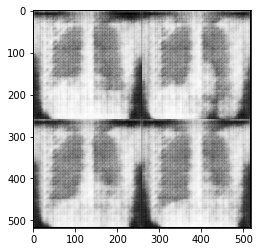


Epoch: 10	Batch: 117/118
Generator Loss: 1.7748985290527344
Discriminator Loss: 0.8796960115432739

Epoch: 11	Batch: 117/118
Generator Loss: 2.260683536529541
Discriminator Loss: 1.833493947982788

Epoch: 12	Batch: 117/118
Generator Loss: 2.0419564247131348
Discriminator Loss: 0.4962984025478363

Epoch: 13	Batch: 117/118
Generator Loss: 2.8582377433776855
Discriminator Loss: 0.7255731821060181

Epoch: 14	Batch: 117/118
Generator Loss: 1.882566213607788
Discriminator Loss: 1.148628830909729

Epoch: 15	Batch: 117/118
Generator Loss: 2.621525764465332
Discriminator Loss: 0.6535971164703369

Epoch: 16	Batch: 117/118
Generator Loss: 1.7381210327148438
Discriminator Loss: 1.5860185623168945

Epoch: 17	Batch: 117/118
Generator Loss: 2.707918643951416
Discriminator Loss: 0.3840133547782898

Epoch: 18	Batch: 117/118
Generator Loss: 3.063640594482422
Discriminator Loss: 0.27857062220573425

Epoch: 19	Batch: 65/118

KeyboardInterrupt: ignored

In [ ]:
while True:
  
  if cur_step % 10 == 0:
    print()
    print(f"Epoch: {epoch}/{n_epochs}")
    print("Example images:")
    generated_images = gen(test_noise).detach().cpu()
    show_tensor_images(generated_images)
    print()
    
  for i, (batch, _) in enumerate(data_loader):
    print(f"\rEpoch: {epoch}\tBatch: {i}/{len(data_loader)}", end='')
    
    # Train the discriminiator ##
    disc.zero_grad()

    # Compute error on real data
    real = Variable(batch).to(gpu)
    real_lab = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
    real_pred = disc(real)
    d_error_real = criterion(real_pred, real_lab)
        
    # Compute error on fake data
    noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(gpu)
    fake = gen(noise)
    fake_pred = disc(fake.detach())
    fake_lab = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(gpu)
    d_error_fake = criterion(fake_pred, fake_lab)
        
    # Accumulate and backpropogate on combined error
    d_error_total = d_error_real + d_error_fake
    d_error_total.backward()
    disc_opt.step()
        
    ## Train the generator ##
    gen.zero_grad()
        
    # Compute rate of fakes being detected
    gen_lab = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
    results = disc(fake)
    g_error = criterion(results, gen_lab)
        
    # Backpropogate and update weights
    g_error.backward()
    gen_opt.step()

  epoch = epoch + 1
  cur_step = cur_step + 1
  print()
  print(f"Generator Loss: {g_error}")
  print(f"Discriminator Loss: {d_error_total}")
  print()

Saving model

In [ ]:
torch.save(gen.state_dict(), "trained_generator")
torch.save(disc.state_dict(), "trained_discriminator")

# 7. Creating Augmented data

In [ ]:
# function to create augmented data

def gen_data(num_img):

  gen = generator()
  gen.load_state_dict(torch.load('trained_generator'))

  noise = torch.randn(num_img, 100, 1, 1)
  
  images = gen(noise).detach()
  show_tensor_images(images)

# creating augmented data

gen_data(4)